In [1]:
import projectpath

import collections
import copy
from importlib import resources
from typing import Iterable, Union

import equilibrator_api
import escher
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import files.pw
from knowledge import kb
from model.core import KbEntry, DbXref, Molecule, Reaction
from model.reaction_network import ReactionNetwork

def labels(entries: Union[KbEntry, Iterable[KbEntry]]):
    if isinstance(entries, KbEntry):
        entries.shorthand or entries.id
    else:
        return [entry.shorthand or entry.id for entry in entries]

def reaction_formula(reaction):
    def reactant_term(reactant, count):
        label = reactant.shorthand or reactant.id
        count = abs(count)
        if count == 1:
            return label
        else:
            return f'{count} {label}'
    
    lhs = [reactant_term(reactant, count) for reactant, count in reaction.stoichiometry.items() if count < 0]
    rhs = [reactant_term(reactant, count) for reactant, count in reaction.stoichiometry.items() if count > 0]
    
    arrow = ' <=> ' if reaction.reversible else ' => '
    
    return ' + '.join(lhs) + arrow + ' + '.join(rhs)

def mode_formula(network, mode):
    parts = []
    for reaction, coeff in zip(labels(network.reactions()), mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction)
    
    return ' '.join(parts)

escher_options = {
    'width': 600,
    'height': 600,
    'map_json': resources.read_text(files.pw, 'glycolysis_ppp_ed.json'),
    'menu': 'zoom',
    'enable_editing': False,
    'never_ask_before_quit': True,
    'metabolite_styles': ['color', 'size'],
    'metabolite_scale': [
        {'type': 'value', 'value': 0.0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 3.0, 'color': '#771fb4', 'size': 30},
    ],
    'reaction_styles': ['color', 'size', 'abs'],
    'reaction_scale': [
        {'type': 'value', 'value': 0.0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 3.0, 'color': '#1f77b4', 'size': 30},
    ],
}

KB = kb.configure_kb()

def kbm(mol_id):
    return KB.get(KB.compounds, mol_id)

def kbr(rxn_id):
    return KB.get(KB.reactions, rxn_id)

cc = equilibrator_api.ComponentContribution()
Q_ = equilibrator_api.Q_
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

def find_cc_met(met):
    if met.xrefs:
        for xref in met.xrefs:
            if xref.db == 'KEGG':
                return cc.get_compound(f'KEGG:{xref.id}')
    return None


In [2]:
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
tca = KB.find(KB.pathways, 'TCA')[0]
ppp = KB.find(KB.pathways, 'pentose phosphate')[0]
glx_shunt = KB.find(KB.pathways, 'glyoxylate shunt')[0]
ent_dou = KB.find(KB.pathways, 'entner-doudoroff')[0]

## Fix cross-references for canonical compounds

In [3]:
import ipysheet

met_data = {
    met: {
        'id': met.id,
        'name': met.name,
        'shorthand': met.shorthand,
        'CHEBI': None,
        'KEGG': None,
        'METACYC': None,
        'save': False,
    } 
    for met in sorted(set([*glycolysis.metabolites, *tca.metabolites, *ppp.metabolites, *glx_shunt.metabolites, *ent_dou.metabolites]), key=lambda m: m.id)
}

for met in met_data:
    for xref in (met.xrefs or []):
        if xref.db in ['CHEBI', 'KEGG', 'METACYC']:
            if met_data[met][xref.db]:
                print(f'{met.id} multiple xrefs to {xref.db}')
            else:
                met_data[met][xref.db] = xref.id

worksheet = ipysheet.from_dataframe(pd.DataFrame(met_data.values()).set_index('id').fillna(''))
worksheet

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=42, row_start=0, squeeze_row=Fals…

In [4]:
for i, row in ipysheet.to_dataframe(worksheet).iterrows():
    met = KB.get(KB.compounds, i)
    data = copy.deepcopy(met.__dict__)
    
    for k in ['name', 'shorthand']:
        if data[k] != row[k]:
            print(f'{met.id} {k}: {data[k]} --> {row[k]}')
            data[k] = row[k]
    
    xrefs = {}
    for db in ['CHEBI', 'KEGG', 'METACYC']:
        if row[db]:
            if not data['xrefs']:
                data['xrefs'] = set()
            xref = DbXref(db=db, id=row[db])
            if xref not in data['xrefs']:
                data['xrefs'].add(xref)
                print(f'{met.id}: add xref {xref}')
                xrefs[xref] = [other for other in KB.xref(KB.compounds, xref_id=xref.id, xref_db=xref.db) if other != met]
                if xrefs[xref]:
                    print(f'    - remove from existing {labels(xrefs[xref])}')

    if row.save:
        for xref, others in xrefs.items():
            for other in others:
                other.xrefs.remove(xref)
                KB.put(KB.compounds, other)
                print(f'Saved {other}')

        met.__dict__.update(data)
        KB.put(KB.compounds, met)
        print(f'Saved {met}')


## Compare reaction $\Delta{G}^{\circ}_r$ values to eQuilibrator site

In [5]:
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

for reaction in glycolysis.steps:
    cc_mets = {}
    for met, count in reaction.stoichiometry.items():
        cc_met = find_cc_met(met)
        cc_mets[met] = (cc_met, count)
    
    cc_rxn = equilibrator_api.Reaction({k: v for k, v in cc_mets.values()})
    
    print(f'[{reaction.id}] {reaction.name}')
    print(f'ΔG = {cc.standard_dg_prime(cc_rxn)}')
    for met, (cc_met, count) in cc_mets.items():
        print(f'    {count:+2d} {(cc.standard_dg_formation(cc_met)[0] or 0.0):8.2f} [{cc_met.id:6d}] [{met.id}] {met.name}')
    print()

[pgi] Glucose-6-phosphate Isomerase
ΔG = (-0.0 +/- 0.4) kilojoule / mole
    -1 -1763.82 [   152] [Glc.D.6P] D-glucose 6-phosphate
    +1 -1760.88 [125172] [Fru.D.6P] D-fructose 6-phosphate

[pfk] 6-phosphofructokinase
ΔG = (-16.2 +/- 0.7) kilojoule / mole
    -1 -2811.58 [     6] [atp] adenosine 5'-triphosphate
    -1 -1760.88 [125172] [Fru.D.6P] D-fructose 6-phosphate
    +1 -1945.43 [    10] [adp] adenosine 5'-diphosphate
    +1 -2598.86 [   396] [Fru.D.bis16] D-fructose 1,6-bisphosphate
    +1     0.00 [     4] [h+] proton

[fbp] Fuctose-bisphosphatase
ΔG = (-14.0 +/- 0.7) kilojoule / mole
    -1 -2598.86 [   396] [Fru.D.bis16] D-fructose 1,6-bisphosphate
    -1  -238.14 [     5] [h2o] water
    +1 -1760.88 [125172] [Fru.D.6P] D-fructose 6-phosphate
    +1 -1095.21 [    12] [pi] phosphate

[fba] Fructose-bisphosphate Aldolase
ΔG = (28.1 +/- 0.5) kilojoule / mole
    -1 -2598.86 [   396] [Fru.D.bis16] D-fructose 1,6-bisphosphate
    +1 -1289.12 [    71] [gap] D-glyceraldehyde 3-phos

### TBD
- CO2 vs CO2[tot], i.e. CO2 + HCO3- etc
  - Could just add the reaction CO2 + H2O <=> CO2[tot]

## State-dependent $\Delta{G} = \Delta{G^{\circ}} + R T ln{Q}$

In [6]:
# All taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4912430/, except where starred
POOLS = {KB.get(KB.compounds, met_id): conc for met_id, conc in [
    ('2pg', 9.18e-02),
    ('3pg', 1.54),
    ('6pg', 3.77),
    ('6pgdl', 1.), # ************
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Rul.D.5P', 1.12e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('accoa', 6.06e-01),
    ('acon', 1.61e-02),
    ('adp', 5.55e-01),
    ('akg', 4.43e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('cit', 1.96),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dhap', 3.06),
    ('dpg', 1.65e-02),
    ('fum', 2.88e-01),
    ('gap', 2.71e-01),
    ('glx', 0.1),  # **********

    # Exclude water and protons from ΔG calculations (justification??)
    # ('h+', 1e-7),
    # ('h2o', 55500),

    ('icit', 3.67e-02),
    ('kdpg', 0.01),  # **********
    ('mal.L', 1.68),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('oaa', 4.87e-04),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('pyr', 3.66),
    ('q.ox', 0.01),  # **********
    ('q.red', 0.01),  # **********
    ('succ', 5.69e-01),
    ('succcoa', 2.33e-01),
]}


In [7]:
class NetReaction:
    def __init__(self, reactions=None):
        self.reactions = collections.defaultdict(int)
        self._stoichiometry = collections.defaultdict(int)
        if reactions is not None:
            for reaction, multiplier in reactions:
                self.add_reaction(reaction, multiplier)
    
    def add_reaction(self, reaction, multiplier):
        for reactant, count in reaction.stoichiometry.items():
            self._stoichiometry[reactant] += count * multiplier
        self.reactions[reaction] += multiplier
    
    @property
    def stoichiometry(self):
        return {met: count for met, count in self._stoichiometry.items() if count != 0}


glyco_mode = [
    (KB.get(KB.reactions, 'pgi'), 1),
    (KB.get(KB.reactions, 'pfk'), 1),
    (KB.get(KB.reactions, 'fba'), 1),
    (KB.get(KB.reactions, 'tpi'), -1),
    (KB.get(KB.reactions, 'gapdh'), 2),
    (KB.get(KB.reactions, 'pgk'), -2),
    (KB.get(KB.reactions, 'gpm.indep'), -2),
    (KB.get(KB.reactions, 'eno'), 2),
]

glyco_net = NetReaction(glyco_mode)
glyco_net.stoichiometry

{[Glc.D.6P] D-glucose 6-phosphate: -1,
 [atp] adenosine 5'-triphosphate: 1,
 [adp] adenosine 5'-diphosphate: -1,
 [h+] proton: 3,
 [nad.ox] NAD: -2,
 [pi] phosphate: -2,
 [nad.red] NADH: 2,
 [h2o] water: 2,
 [pep] phosphoenolpyruvate: 2}

In [8]:
def calculate_dg(reaction, concs):
    cc_stoich = {}
    rxn_q = 1.0
    for met, count in reaction.stoichiometry.items():
        cc_stoich[find_cc_met(met)] = count
        if met in concs:
            # Concentrations are in mM, but ΔG is standardized on M
            rxn_q = rxn_q * (concs[met] * 1e-3)**count

    cc_rxn = equilibrator_api.Reaction(cc_stoich)
    dg0 = cc.standard_dg_prime(cc_rxn)
    dg = dg0 + cc.RT * np.log(rxn_q)
    return dg0, dg

coeffs = []
dg0s = []
dgs = []
for reaction, coeff in glyco_mode:
    coeffs.append(coeff)
    dg0, dg = calculate_dg(reaction, POOLS)
    # TODO: figure out pint (units) and uncertainties. For now, jump straight to the value
    dg0s.append(dg0.n)
    dgs.append(dg.n)

coeffs = np.array(coeffs)
dg0s = np.array(dg0s)
dgs = np.array(dgs)

**TODO**: figure out [pint](https://pint.readthedocs.io/en/stable/) (_i.e._ units) and [uncertainties](https://pythonhosted.org/uncertainties/) packages

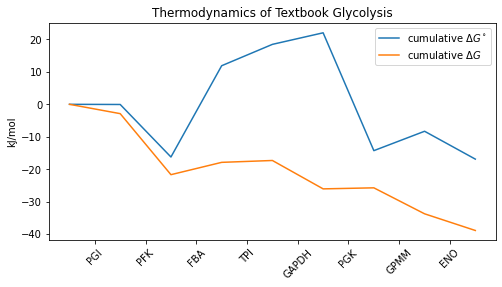

In [9]:
path0 = np.insert(np.cumsum(dg0s * coeffs), 0, 0)
path = np.insert(np.cumsum(dgs * coeffs), 0, 0)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(path0, label='cumulative $\Delta{G}^{\circ}$')
ax.plot(path, label='cumulative $\Delta{G}$')
ax.set_xticks(np.arange(len(glyco_mode)) + 0.5, labels(rxn for rxn, coeff in glyco_mode), rotation=45)
ax.set_title('Thermodynamics of Textbook Glycolysis')
ax.set_ylabel('kJ/mol')
ax.legend()
plt.show()

- In isolation, FBA looks irreversible in the wrong direction, and PGK in the right one.
- But considering metabolite concentrations, each is pretty close to equilibrium
- Overall path is substantially downhill _under these conditions_


# Systematic Calculations (Glycolysis + PPP)

In [10]:
std_dg_r = {}
for rxn in glycolysis.steps + tca.steps + ppp.steps + glx_shunt.steps + ent_dou.steps + [kbr(rxn_id) for rxn_id in ('ppc', 'ppck', 'mae.nad', 'mae.nadp')]:
    cc_rxn = equilibrator_api.Reaction({find_cc_met(met): count for met, count in rxn.stoichiometry.items()})
    std_dg_r[rxn] = cc.standard_dg_prime(cc_rxn)

### Using matrix math:

$\Delta{G}_r = \Delta{G}_r^\circ + RT \cdot ln{(\frac{\prod{c_p}}{\prod{c_s}})}$

$ = \Delta{G}_r^\circ + RT \cdot (ln(\prod{c_p})- ln(\prod{c_s}))$

$ = \Delta{G}_r^\circ + RT \cdot \sum\limits_i{S_{i,r} ln (c_i)}$

$\vec{\Delta{G}_r} = \vec{\Delta{G}^\circ} + RT \cdot (\mathbf{S} \cdot ln (\vec{c}))$


In [11]:
network = ReactionNetwork(r for r in glycolysis.steps + ppp.steps if r.id not in ('pyk', 'pps', 'pdh'))
print(network.s_matrix.shape)

dg0 = np.array([std_dg_r[rxn].n for rxn in network.reactions()])
ln_conc = np.log(np.array([POOLS.get(met, 1e3) * 1e-3 for met in network.reactants()]))
dg = dg0 + cc.RT.magnitude * network.s_matrix.T @ ln_conc

pd.Series(dg, index=labels(network.reactions()))

(26, 17)


PGI       -2.874524
PFK      -18.795882
FBP      -27.654230
FBA        3.795067
TPI       -0.574578
GAPDH     -4.371253
PGK       -0.159990
GPMM       4.000982
ENO       -2.567201
R5PI      -1.633633
TKT1       1.166628
RPE       -2.273729
PGLase   -22.528238
PGLDH    -11.504466
TALA      -6.467252
TKT2      -3.183528
G6PDH     -0.952827
dtype: float64

## Thermodynamics of Elementary Modes

In [12]:
def build_internal_system(network, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in network.reactants()]
    return network.s_matrix[intermediates].astype(int)

def sort_tableau(tableau, j):
    # Existing modes that already satisfy steady state j will be part of the next tableau. Others will either be merged or dropped.
    elementary = []
    pending = []
    for mode, reversible, zeros in tableau:
        if mode[j] == 0:
            elementary.append((mode, reversible, zeros))
        else:
            pending.append((mode, reversible, zeros))
    return elementary, pending

def generate_candidates(pending, j):
    # All pending mode pairs are merge candidates, unless they violate irreversibility.
    candidates = []
    for i, (mode_i, reversible_i, zeros_i) in enumerate(pending):
        for mode_m, reversible_m, zeros_m in pending[i+1:]:
            # Put a reversible mode second if possible, so we can always multiply the first by a positive number
            if reversible_m:
                candidates.append((mode_i, mode_m, reversible_i and reversible_m, zeros_i & zeros_m))
            elif reversible_i:
                candidates.append((mode_m, mode_i, reversible_i and reversible_m, zeros_i & zeros_m))

            # Otherwise we can still combine them, if they have opposite stoichiometry
            elif mode_i[j] * mode_m[j] < 0:
                candidates.append((mode_i, mode_m, False, zeros_i & zeros_m))
    return candidates

def merge_modes(mode_i, mode_m, reversible, j, num_rxns):
    # All integer arithmetic. We want integer scaling in simplest form.
    multiple = int(np.lcm(mode_i[j], mode_m[j]))
    # scale_i is always positive
    scale_i = int(multiple / abs(mode_i[j]))
    # scale_m satisfies scale_i * mode_i[j] + scale_m * mode_m[j] = 0. 
    scale_m = -int(scale_i * mode_i[j] / mode_m[j])

    # Combine modes, and reduce to simplest integers.
    mode = scale_i * mode_i + scale_m * mode_m
    mode = (mode / np.gcd.reduce(mode)).astype(int)
    
    # Determine the actual new zeros set on the moerged mode.
    zeros = set(np.nonzero(mode[-num_rxns:] == 0)[0])
    
    # Mostly esthetic, but prefer original reaction direction for reversible modes
    if reversible:
        involved = num_rxns - len(zeros)
        forward = np.nonzero(mode[-num_rxns:] > 0)[0].shape[0]
        if forward * 2 < involved:
            mode = -mode

    return mode, reversible, zeros

def process_candidates(candidates, modes, j, num_rxns):
    # Compare candidates against all other elementary modes, based on the non-subset zeros test.
    for i, (mode_i, mode_m, reversible, zeros) in enumerate(candidates):
        passing = True
        for _, _, other_zeros in modes:
            if zeros <= other_zeros:  # subset or equal
                # print(f'  {mode_i} + {mode_m} Fails because {zeros} <= {other_zeros}')
                passing = False
                break

        # If the candidate survived, keep it. Other candidates must now compare against this new mode too.
        if passing:
            modes.append(merge_modes(mode_i, mode_m, reversible, j, num_rxns))
    
    return modes

# def elementary_modes(network, bounds):
def elementary_modes(s_matrix, reversibilities):
    # tableau = init_tableau(network, bounds)
    num_mets, num_rxns = s_matrix.shape
    modes = list(np.concatenate([s_matrix, np.eye(num_rxns, dtype=int)]).T)
    tableau = [(mode, reversible, set(np.nonzero(mode[-num_rxns:] == 0)[0]))
                for mode, reversible in zip(modes, reversibilities)]

    for j in range(num_mets):
        modes, pending = sort_tableau(tableau, j)
        candidates = generate_candidates(pending, j)
        # TODO: optimization based on cardinality of merged zeros set, per Urbanczik & Wagner (2004)?
        
        tableau = process_candidates(candidates, modes, j, num_rxns)
        
    modes = []
    rev = []
    for mode, reversible, zeros in tableau:
        modes.append(mode[-num_rxns:])
        rev.append(reversible)
    
    return np.array(modes, dtype=int).T, rev


def show_modes(network, modes, rev, map_json=None):
    s_elementary = (network.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(network.reactants(), mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(_id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='flux ratios', layout={'width': '100%'})
    mode_net = widgets.Text(description='net reaction', layout={'width': '100%'})

    diag = escher.Builder(**escher_options)
    if map_json:
        diag.map_json = resources.read_text(files.pw, 'central_carbon.json')

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(network, modes.T[mode])
        mode_net.value = reaction_formula(net_reactions[mode])
        diag.reaction_data = {r: v for r, v in zip(labels(network.reactions()), modes.T[mode])}

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([mode_select, mode_fluxes, mode_net, diag])

In [13]:
bounds = {KB.get(KB.compounds, met_id) for met_id in [
    'Glc.D.6P',
    'Rib.D.5P',
    'pep',
    'co2',
    'amp',
    'adp',
    'atp',
    'nad.ox',
    'nad.red',
    'nadp.ox',
    'nadp.red',
    'pi',
    'h2o',
    'h+',
]}

modes, rev = elementary_modes(build_internal_system(network, bounds), [rxn.reversible for rxn in network.reactions()])
pd.DataFrame(modes, index=labels(network.reactions()))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
PGI,0,1,-1,0,-2,0,0,-2,0,0,5,5,-5,-5
PFK,1,1,0,0,0,2,0,0,2,0,1,1,0,0
FBP,1,0,1,0,0,0,2,0,0,2,0,0,1,1
FBA,0,1,-1,0,0,2,-2,0,2,-2,1,1,-1,-1
TPI,0,-1,1,0,0,-2,2,0,-2,2,-1,-1,1,1
GAPDH,0,2,-2,0,1,5,-5,1,5,-5,0,0,0,0
PGK,0,-2,2,0,-1,-5,5,-1,-5,5,0,0,0,0
GPMM,0,-2,2,0,-1,-5,5,-1,-5,5,0,0,0,0
ENO,0,2,-2,0,1,5,-5,1,5,-5,0,0,0,0
R5PI,0,0,0,-1,2,2,-2,0,0,0,-4,0,4,0


$\Delta{G}_m = \sum\limits_r {m_r \Delta{G}_r}$

$\vec{\Delta{G}_m} = \mathbf{M^T} \cdot \vec{\Delta{G}}_r$

In [14]:
modes.T @ dg

array([ -46.45011234,  -38.85965562,   -7.59045672,  -33.35189808,
        -23.66252952, -101.38184076,    8.48161608,  -90.36632569,
       -168.08563693,   75.18541224,    8.46540343,  141.87299575,
        -54.91551577, -188.3231081 ])

In [16]:
show_modes(network, modes, rev)

# Elementary Modes of TCA (+ anaplerosis)

In [17]:
network = ReactionNetwork(r for r in tca.steps + glx_shunt.steps + [kbr(rxn_id) for rxn_id in ('pyk', 'pps', 'pdh', 'ppc', 'ppck', 'mae.nad', 'mae.nadp')])
print(network.s_matrix.shape)

diag = escher.Builder(**escher_options)
diag.map_json = resources.read_text(files.pw, 'central_carbon.json')
diag.reaction_data = {r: 1 for r in labels(network.reactions())}
diag

(27, 18)


Builder(enable_editing=False, height=600, menu='zoom', metabolite_scale=[{'type': 'value', 'value': 0.0, 'colo…

In [18]:
boundaries = {
    kbm('pep'), kbm('pyr'), kbm('accoa'), kbm('oaa'), kbm('akg'),
    kbm('amp'), kbm('adp'), kbm('atp'), kbm('pi'),
    kbm('nad.ox'), kbm('nad.red'), kbm('nadp.ox'), kbm('nadp.red'), kbm('q.ox'), kbm('q.red'),    
    kbm('coa'),    
    kbm('h+'), kbm('h2o'), kbm('co2')
}
# Possibly treat a subset of the boundaries as exchanges
exchanges = {
    kbm('pep'): 0,
    kbm('pyr'): 0,
    kbm('accoa'): -1,
    kbm('oaa'): -1,
    kbm('akg'): -1,
}

def augmented_internal_system(network, bounds, exchanges):
    """Returns S matrix with rows for internal and exchanged metabolites only."""
    
    # Append columns ('reactions') with a single entry for each exchange
    exchange_cols = np.zeros((network.shape[0], len(exchanges)), dtype=int)
    for j, (met, direction) in enumerate(exchanges.items()):
        exchange_cols[network.reactant_index(met), j] = direction or 1

    intermediates = [met not in bounds for met in network.reactants()]
    s_matrix = np.concatenate([network.s_matrix.astype(int), exchange_cols], axis=1)
    reversibility = [reaction.reversible for reaction in network.reactions()]
    reversibility.extend(direction == 0 for met, direction in exchanges.items())
    return s_matrix[intermediates],  reversibility

internal_system, reversibility = augmented_internal_system(network, boundaries - exchanges.keys(), exchanges)
print(internal_system.shape, len(reversibility))
modes, mrev = elementary_modes(internal_system, reversibility)
modes = modes[:network.shape[1]]
print(f'{modes.shape[1]} elementary modes')

show_modes(network, modes, mrev, map_json='central_carbon.json')

(13, 23) 23
113 elementary modes


## Use current $\Delta{G}_r$ to constrain reaction direction 

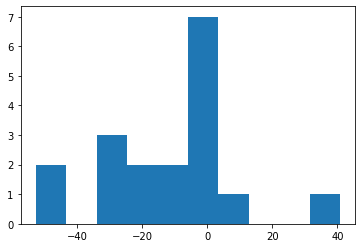

ICD      -3.372707
AKGDH   -48.229917
SCS      -9.620471
ACN2      3.285738
FH       -0.903246
CS      -17.524282
SDH     -25.277125
ACN1     -0.033476
MDH      -0.372701
MS      -25.828589
ICL      -6.727101
PYK      12.755788
PPS     -26.237576
PDH     -52.686754
PPC      40.831996
PPCK     -5.618116
ME1     -18.746605
ME2      -3.189822
dtype: float64

In [18]:
dg0 = np.array([std_dg_r[rxn].n for rxn in network.reactions()])
ln_conc = np.log(np.array([POOLS.get(met, 1e3) * 1e-3 for met in network.reactants()]))
dg = dg0 + cc.RT.magnitude * network.s_matrix.T @ ln_conc

plt.hist(dg)
plt.show()

pd.Series(dg, index=labels(network.reactions()))

### Strategy:
- Use a vector of +1 & -1 to set thermodynamic direction of each reaction
    - Operates directly on the S matrix, leaves `network` unchanged, requires no changes to Reaction objects
- Reversibility based on |ΔG| < threshold, _overriding_ any preset reversibility on the Reaction.
    - Strictly speaking, threshold should 0, but positive threshold allows for uncertainty in ΔG° and/or Q
    - Eventually, use uncertainty directly instead of a threshold parameter?

In [19]:
print(dg)

direction = (-dg / np.abs(dg)).astype(int)
print(direction)

threshold = 5.0
reversibility = np.abs(dg) < threshold
print(reversibility)


[-3.37270737e+00 -4.82299172e+01 -9.62047124e+00  3.28573788e+00
 -9.03246123e-01 -1.75242821e+01 -2.52771252e+01 -3.34760646e-02
 -3.72700919e-01 -2.58285888e+01 -6.72710142e+00  1.27557881e+01
 -2.62375757e+01 -5.26867536e+01  4.08319961e+01 -5.61811623e+00
 -1.87466053e+01 -3.18982175e+00]
[ 1  1  1 -1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1]
[ True False False  True  True False False  True  True False False False
 False False False False False  True]


In [20]:
# Interaction between augmented system and thermo-reversibility. Need to clean this up in the final API, but just muddle through for now

threshold = 5.0
internal_system, raw_rev = augmented_internal_system(network, boundaries - exchanges.keys(), exchanges)
augments = len(exchanges)
direction = np.append(-dg / np.abs(dg), np.ones(augments)).astype(int)
reversibility = np.append(np.abs(dg) < threshold, raw_rev[-augments:])
print(internal_system.shape, direction.shape, reversibility.shape)

modes, mrev = elementary_modes(internal_system * direction, reversibility)
modes = (modes.T * direction).T[:network.shape[1]]
print(f'{modes.shape[1]} elementary modes')

show_modes(network, modes, mrev, map_json='central_carbon.json')

(13, 23) (23,) (23,)
41 elementary modes


Interesting. Not one of the thermodynamic modes includes the textbook TCA cycle.
- The culprit is Succinyl CoA synthetase, which is thermodynamically irreversible in the wrong direction to allow cyclic flux
    - If I set the threshold >= 9.7 the cycle appears as a mode. But that's a pretty big miss.
- Is the reported concentration of succCoA too low? Or does biosynthesis consume enough succCoA to keep it low (and disallow the cycle)?